In [580]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import os
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle
import time
from datetime import datetime
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

In [581]:
train_df = pd.read_csv("/opt/ml/input/data/train_data.csv")
test_df = pd.read_csv("/opt/ml/input/data/test_data.csv")

In [582]:
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [583]:
def add_user_recent_acc(train_df, shift_size=5):
    train_df = train_df.sort_values(by=['userID'])
    train_df_temp = train_df.copy()

    # 새롭게 이력이 시작되는 유저 구함
    user_start_pos = train_df['userID'].diff() > 0
    train_df_temp['previous_answer_count'] = train_df_temp.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    train_df_temp['shift_previous_answer_count'] = train_df_temp.groupby('userID')['answerCode'].cumsum().shift(fill_value=0)
    train_df_temp.loc[user_start_pos, ['previous_answer_count', 'shift_previous_answer_count']] = 0
    train_df_temp['shift_previous_answer_count'] = train_df_temp['shift_previous_answer_count'].shift(shift_size)
    train_df_temp['temp'] = len(train_df_temp) * [1]
    train_df_temp['previous_problem_count'] = train_df_temp.groupby('userID')['temp'].cumsum().shift(fill_value=0)
    train_df_temp['previous_problem_count'] = train_df_temp['previous_problem_count'].apply(lambda x: shift_size if x > shift_size else x)
    train_df_temp.loc[user_start_pos, ['previous_problem_count']] = 0

    train_df_temp['shift_previous_answer_count'] = train_df_temp.apply(lambda x: 0 if x['previous_problem_count'] < shift_size else x['shift_previous_answer_count'], axis=1)
    train_df_temp['count'] = train_df_temp['previous_answer_count'] - train_df_temp['shift_previous_answer_count']
    train_df['user_recent_acc'] = (train_df_temp['count'] / train_df_temp['previous_problem_count']).fillna(0)
    return train_df

In [584]:
# make sum_rel_point, 'item_ans_rate' feature 사용
def fill_rel_point(df):
    arr = np.zeros(len(df))
    start_idx = 0

    for i in range(len(df)):
        row = df.iloc[i, :].copy()
        answer = row['answerCode']
        item_ans_rate = row['item_ans_rate']

        if answer == 1:
            arr[i] = 1 - item_ans_rate
        elif answer == 0:
            arr[i] = - item_ans_rate
        elif answer == -1:

            avg_rel_point = np.mean(arr[start_idx : i])
            start_idx = i + 1
            arr[i] = avg_rel_point

    df['rel_point'] = pd.Series(arr)
    return df

def sum_point(df):
    grouped = df.groupby('userID')['rel_point']
    arr = np.zeros(len(df))
    start_idx = 0
    cnt = 0
    for _, group in grouped:
        cnt += 1
        point_sum = group.iloc[:len(group)-1].sum()
        arr[start_idx:start_idx+len(group)] = point_sum
        start_idx = start_idx + len(group)

    df['sum_rel_point'] = pd.Series(arr)
    return df

In [585]:
def add_user_test_exp(df):
    # 유저가 해당 시험을 풀어본 경험이 있는지
    df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

    df["user_test_exp"] = df.groupby(["userID", "testId"])['testId'].cumcount()
    df['user_test_exp'] = df["user_test_exp"].apply(lambda x : 1 if x > 0 else 0)
    return df

In [586]:
train_df = add_user_recent_acc(train_df)
test_df = add_user_recent_acc(test_df)

In [587]:
# train_df = add_user_problem_exp(train_df)
# test_df = add_user_problem_exp(test_df)

In [588]:
# train_df = add_user_test_exp(train_df)
# test_df = add_user_test_exp(test_df)

In [589]:
# train_df

In [590]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.8):

    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [591]:
def feature_engineering(df):
    scaler= MinMaxScaler()
    def convert_time(s):
        timestamp = time.mktime(
            datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()
        )
        return int(timestamp)

    df["Timestamp"] = df["Timestamp"].apply(convert_time)

    # --- diff
    # df['diff'] = df.sort_values(['userID','Timestamp']).groupby('userID')['Timestamp'].diff(periods=1).apply(abs)
    df['diff'] = df.sort_values(['userID','Timestamp']).groupby('userID')['Timestamp'].diff()

    # nan은 -1
    # 600(10분) 이상이면 다 600
    df['diff'].fillna(-1, inplace=True)
    idx = df[df['diff'] >= 600].index
    df.loc[idx, 'diff'] = 600

    # # --- mean 태그별 문제 풀이 평균 시간
    tmp= df[df['diff']>=0]
    correct_k= tmp.groupby(['KnowledgeTag'])['diff'].agg(['mean'])
    df= pd.merge(df, correct_k, on=['KnowledgeTag'], how= 'left')
    # df['mean']= scaler.fit_transform(df['mean'].values.reshape(-1, 1)).reshape(-1) # minmax scaling


    # --- before_tag 이전 태그 문제 풀이 여부
    df2= df.sort_values(['userID','KnowledgeTag','Timestamp'])
    df2.reset_index(inplace=True, drop=True)
    df2['cumsum']= df2.groupby(['userID','KnowledgeTag'])['answerCode'].cumsum()
    df2['temp']= 1
    df2['seq']= df2.groupby(['userID','KnowledgeTag'])['temp'].cumsum()
    df2.drop(['temp'], axis=1, inplace=True)
    df2['cumsum'] -= df2['answerCode']

    df2['seq'] -= 1
    df2['before_tag']= df2['cumsum']/df2['seq']

    tag_avg= dict(df2.groupby(['KnowledgeTag'])['answerCode'].mean())
    def match_avg(x):
        if x>1:
            return tag_avg[x]
        else:
            return x

    df2['before_tag'].fillna(df2.KnowledgeTag, inplace=True)
    df2['before_tag']= df2['before_tag'].apply(match_avg)
    df2.loc[df2[df2['before_tag'] >= 0.5].index,'before_tag'] = 1
    df2.loc[df2[df2['before_tag'] < 0.5].index,'before_tag'] = 0

    df= pd.merge(df2[['userID','assessmentItemID','Timestamp','before_tag']],df, on=['userID','assessmentItemID','Timestamp'])

    # # --- user_correct_answer
    df2= df.sort_values(by=['userID','Timestamp'])
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_correct_answer'].fillna(0)

    # # --- user_acc
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']

    # df2['user_correct_answer']= scaler.fit_transform(df2['user_correct_answer'].values.reshape(-1, 1)).reshape(-1)

    # # test mean, sum
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    # df2['test_mean']= scaler.fit_transform(df2['test_mean'].values.reshape(-1,1)).reshape(-1)
    # df2['test_sum']= scaler.fit_transform(df2['test_sum'].values.reshape(-1,1)).reshape(-1)

    df= pd.merge(df2[['userID','assessmentItemID','Timestamp','user_correct_answer', 'user_acc', 'test_mean', 'test_sum']],df, on=['userID','assessmentItemID','Timestamp'])

    # # --- test_seq
    df2= df.sort_values(['userID','testId','Timestamp'])
    df2.reset_index(inplace=True, drop=True)
    df2['test_seq']= df2.groupby(['userID','testId']).cumcount()
    # self.args.num_test_seq= df2['test_seq'].max()+2 # 개수 + 패딩
    df= pd.merge(df2[['userID','assessmentItemID','Timestamp','test_seq']], df, on=['userID','assessmentItemID','Timestamp'])

    # # --- Timestamp 스케일링
    # df['Timestamp']= scaler.fit_transform(df['Timestamp'].values.reshape(-1,1)).reshape(-1)

    df['item']= df['assessmentItemID']

    def percentile(s):
        return np.sum(s) / len(s)
    prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile})
    num_mean= prob_groupby.userID.mean()

    knowledgetags = df.KnowledgeTag
    knowledgetag_stroke = np.zeros(knowledgetags.shape)

    for i, k in enumerate(knowledgetags):
        if i == 0:
            continue

        if k == knowledgetags[i-1]:
            knowledgetag_stroke[i] = knowledgetag_stroke[i-1] + 1

    df['knowledgetag_stroke'] = knowledgetag_stroke

    return df

    # # 태그 유형별 정답률
    # din_tag= np.load('/opt/ml/input/data/din_tag.npy')
    # in_tag= np.load('/opt/ml/input/data/in_tag.npy')

    # tag= df[['assessmentItemID','KnowledgeTag']]
    # tag= tag.drop_duplicates('assessmentItemID', keep='first')
    # prob_groupby= pd.merge(prob_groupby, tag, on='assessmentItemID', how='right')

    # up_avg= prob_groupby[prob_groupby.userID >= num_mean]
    # down_avg= prob_groupby[prob_groupby.userID < num_mean]

    # up_avg1= pd.DataFrame(up_avg.groupby('KnowledgeTag').agg({'answerCode':'mean'}))
    # up_avg1.reset_index(inplace=True)
    # up_avg1.rename({'answerCode':'tagAr'}, axis=1, inplace=True)
    # down_avg1= pd.DataFrame(down_avg.groupby('KnowledgeTag').agg({'answerCode':'mean'}))
    # down_avg1.reset_index(inplace=True)
    # down_avg1.rename({'answerCode':'tagAr'}, axis=1, inplace=True)

    # # ## 로그 스케일링
    # up_avg1.loc[up_avg1[up_avg1.KnowledgeTag.isin(in_tag)].index,'tagAr']=up_avg1[up_avg1.KnowledgeTag.isin(in_tag)]['tagAr'].apply(np.log1p)
    # down_avg1.loc[down_avg1[down_avg1.KnowledgeTag.isin(din_tag)].index,'tagAr']=down_avg1[down_avg1.KnowledgeTag.isin(din_tag)]['tagAr'].apply(np.log1p)

    # new_up_avg= pd.merge(up_avg, up_avg1,on='KnowledgeTag')
    # new_down_avg= pd.merge(down_avg, down_avg1,on='KnowledgeTag')

    # new_down_avg.tagAr *=new_down_avg.userID/1000
    # new_down_avg.tagAr *=new_down_avg.userID/1000

    # new_= pd.concat([new_up_avg, new_down_avg], axis=0)
    # df= pd.merge(new_[['assessmentItemID','KnowledgeTag']], df, on=['assessmentItemID','KnowledgeTag'], how='left')

In [592]:
from sklearn.preprocessing import MinMaxScaler

def scaling(df, ms=None, tms=None, ts=None, tss=None, is_train=True):

    if is_train:
        mean_scaler = MinMaxScaler()
        test_mean_scalar = MinMaxScaler()
        tmestamp_scalar = MinMaxScaler()
        test_sum_scalar = MinMaxScaler()

        df['mean'] = mean_scaler.fit_transform(df['mean'].values.reshape(-1, 1))
        df['test_mean'] = test_mean_scalar.fit_transform(df['test_mean'].values.reshape(-1, 1))
        df['Timestamp'] = tmestamp_scalar.fit_transform(df['Timestamp'].values.reshape(-1, 1))
        df['test_sum'] = test_sum_scalar.fit_transform(df['test_sum'].values.reshape(-1, 1))

        return mean_scaler, test_mean_scalar, tmestamp_scalar, test_sum_scalar, df

    else:
        df['mean'] = ms.transform(df['mean'].values.reshape(-1, 1))
        df['test_mean'] = tms.transform(df['test_mean'].values.reshape(-1, 1))
        df['Timestamp'] = ts.transform(df['Timestamp'].values.reshape(-1, 1))
        df['test_sum'] = tss.transform(df['test_sum'].values.reshape(-1, 1))

        return df

In [593]:
train_df_fe = feature_engineering(train_df)

In [594]:
train_df_fe

,userID,assessmentItemID,Timestamp,test_seq,user_correct_answer,user_acc,test_mean,test_sum,before_tag,testId,answerCode,KnowledgeTag,user_recent_acc,diff,mean,item,knowledgetag_stroke
0,0,A020172001,1602414407,0,359.0,0.614726,0.581573,991,1.0,A020000172,1,8132,0.6,600.0,168.459953,A020172001,0.0
1,0,A020172002,1602414416,1,360.0,0.615385,0.581573,991,1.0,A020000172,1,8132,0.8,9.0,168.459953,A020172002,1.0
2,0,A020172003,1602414433,2,361.0,0.616041,0.581573,991,1.0,A020000172,1,8132,0.8,17.0,168.459953,A020172003,2.0
3,0,A020172004,1602414466,3,362.0,0.616695,0.581573,991,1.0,A020000172,1,8132,1.0,33.0,168.459953,A020172004,3.0
4,0,A020172005,1602414500,4,363.0,0.617347,0.581573,991,1.0,A020000172,0,8132,1.0,34.0,168.459953,A020172005,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,1591339821,4,1.0,0.250000,0.662590,921,0.0,A030000071,0,438,0.4,24.0,160.095250,A030071005,4.0
2266582,7441,A040165001,1597971999,0,1.0,0.200000,0.655109,718,1.0,A040000165,1,8836,0.2,600.0,162.502079,A040165001,0.0
2266583,7441,A040165002,1597972010,1,2.0,0.333333,0.655109,718,1.0,A040000165,1,8836,0.4,11.0,162.502079,A040165002,1.0
2266584,7441,A040165003,1597972056,2,3.0,0.428571,0.655109,718,1.0,A040000165,1,8836,0.0,46.0,162.502079,A040165003,2.0


In [595]:
test_df_fe = feature_engineering(test_df)
test_df_fe

,userID,assessmentItemID,Timestamp,test_seq,user_correct_answer,user_acc,test_mean,test_sum,before_tag,testId,answerCode,KnowledgeTag,user_recent_acc,diff,mean,item,knowledgetag_stroke
0,3,A020001001,1583974749,0,152.0,0.734300,0.751515,124,1.0,A020000001,1,7916,0.800000,600.0,154.753982,A020001001,0.0
1,3,A020001002,1583974765,1,153.0,0.735577,0.751515,124,1.0,A020000001,1,7916,0.800000,16.0,154.753982,A020001002,1.0
2,3,A020001003,1583974774,2,154.0,0.736842,0.751515,124,1.0,A020000001,1,7916,0.800000,9.0,154.753982,A020001003,2.0
3,3,A020001004,1583974819,3,155.0,0.738095,0.751515,124,1.0,A020000001,1,7916,0.800000,45.0,154.753982,A020001004,3.0
4,3,A020001005,1583974873,4,156.0,0.739336,0.751515,124,1.0,A020000001,0,7916,0.800000,54.0,154.753982,A020001005,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040197002,1597995317,1,5.0,0.833333,0.744792,143,1.0,A040000197,1,2132,1.000000,11.0,137.909561,A040197002,1.0
260110,7439,A040197003,1597995371,2,6.0,0.857143,0.744792,143,1.0,A040000197,1,2132,0.400000,54.0,137.909561,A040197003,2.0
260111,7439,A040197004,1597995541,3,7.0,0.875000,0.744792,143,1.0,A040000197,0,2132,0.600000,170.0,137.909561,A040197004,3.0
260112,7439,A040197005,1597995580,4,7.0,0.777778,0.744792,143,1.0,A040000197,0,2132,0.750000,39.0,137.909561,A040197005,4.0


In [596]:
inference = test_df_fe.loc[test_df_fe['answerCode'] == -1]
inference

,userID,assessmentItemID,Timestamp,test_seq,user_correct_answer,user_acc,test_mean,test_sum,before_tag,testId,answerCode,KnowledgeTag,user_recent_acc,diff,mean,item,knowledgetag_stroke
981,3,A050133008,1603718037,7,717.0,0.692754,0.661765,90,1.0,A050000133,-1,5289,0.8,46.0,155.505119,A050133008,1.0
1706,4,A070146008,1609037274,7,465.0,0.694030,0.740385,77,1.0,A070000146,-1,9080,0.8,23.0,70.113139,A070146008,1.0
2965,13,A070111008,1609043709,7,915.0,0.695289,0.417857,117,0.0,A070000111,-1,9660,0.8,8.0,56.877922,A070111008,3.0
4269,17,A090064006,1604036917,5,1031.0,0.818904,0.625000,30,1.0,A090000064,-1,2611,1.0,75.0,126.514286,A090064006,5.0
4661,26,A060135007,1603453458,6,293.0,0.759067,0.678571,133,1.0,A060000135,-1,1422,0.8,17.0,152.871542,A060135007,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260043,7395,A040122005,1599530720,4,7.0,0.304348,0.753846,147,0.0,A040000122,-1,10615,0.0,2.0,138.070588,A040122005,0.0
260062,7404,A030111005,1602582558,4,7.0,0.500000,0.866667,156,1.0,A030000111,-1,7636,0.0,107.0,154.634731,A030111005,4.0
260076,7416,A050193004,1601779481,3,7.0,0.500000,0.750000,75,1.0,A050000193,-1,10402,0.4,24.0,141.636054,A050193004,3.0
260097,7417,A050193004,1599397755,3,2.0,0.142857,0.750000,75,1.0,A050000193,-1,10402,0.0,21.0,141.636054,A050193004,3.0


In [597]:
infer_test = test_df_fe.loc[test_df_fe['answerCode'] != -1]
infer_test

,userID,assessmentItemID,Timestamp,test_seq,user_correct_answer,user_acc,test_mean,test_sum,before_tag,testId,answerCode,KnowledgeTag,user_recent_acc,diff,mean,item,knowledgetag_stroke
0,3,A020001001,1583974749,0,152.0,0.734300,0.751515,124,1.0,A020000001,1,7916,0.800000,600.0,154.753982,A020001001,0.0
1,3,A020001002,1583974765,1,153.0,0.735577,0.751515,124,1.0,A020000001,1,7916,0.800000,16.0,154.753982,A020001002,1.0
2,3,A020001003,1583974774,2,154.0,0.736842,0.751515,124,1.0,A020000001,1,7916,0.800000,9.0,154.753982,A020001003,2.0
3,3,A020001004,1583974819,3,155.0,0.738095,0.751515,124,1.0,A020000001,1,7916,0.800000,45.0,154.753982,A020001004,3.0
4,3,A020001005,1583974873,4,156.0,0.739336,0.751515,124,1.0,A020000001,0,7916,0.800000,54.0,154.753982,A020001005,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040197002,1597995317,1,5.0,0.833333,0.744792,143,1.0,A040000197,1,2132,1.000000,11.0,137.909561,A040197002,1.0
260110,7439,A040197003,1597995371,2,6.0,0.857143,0.744792,143,1.0,A040000197,1,2132,0.400000,54.0,137.909561,A040197003,2.0
260111,7439,A040197004,1597995541,3,7.0,0.875000,0.744792,143,1.0,A040000197,0,2132,0.600000,170.0,137.909561,A040197004,3.0
260112,7439,A040197005,1597995580,4,7.0,0.777778,0.744792,143,1.0,A040000197,0,2132,0.750000,39.0,137.909561,A040197005,4.0


In [598]:
train, test = custom_train_test_split(train_df_fe)
mean_sc, test_mean_sc, tmestamp_sc, test_sum_sc, train = scaling(train)
test = scaling(test, mean_sc, test_mean_sc, tmestamp_sc, test_sum_sc, is_train=False)
inference = scaling(inference, mean_sc, test_mean_sc, tmestamp_sc, test_sum_sc, is_train=False)
infer_test = scaling(infer_test, mean_sc, test_mean_sc, tmestamp_sc, test_sum_sc, is_train=False)

/tmp/ipykernel_12210/3536737570.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = mean_scaler.fit_transform(df['mean'].values.reshape(-1, 1))
/tmp/ipykernel_12210/3536737570.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['test_mean'] = test_mean_scalar.fit_transform(df['test_mean'].values.reshape(-1, 1))
/tmp/ipykernel_12210/3536737570.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [601]:
features = ['assessmentItemID', 'answerCode', 'user_acc', 'testId', 'test_mean',
                'before_tag', 'diff', 'user_recent_acc', 'knowledgetag_stroke']

In [602]:
categorical_cols =  ['assessmentItemID', 'testId', 'before_tag']
# categorical_cols =  ['assessmentItemID', 'before_tag']
# train = train[['assessmentItemID', 'answerCode', 'user_acc', 'testId', 'test_mean', 'before_tag', 'diff', 'user_recent_acc']]
train = train[features]
train[categorical_cols] = train[categorical_cols].fillna("")
train['diff'] = train['diff'].astype(int)
train['before_tag'] = train['before_tag'].astype(int)
# train[['before_tag', 'diff']] = train[['before_tag', 'diff']].astype(int)
# train.drop(columns=['Timestamp'], inplace=True)
train

/tmp/ipykernel_12210/1152382678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[categorical_cols] = train[categorical_cols].fillna("")
/tmp/ipykernel_12210/1152382678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['diff'] = train['diff'].astype(int)
/tmp/ipykernel_12210/1152382678.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,assessmentItemID,answerCode,user_acc,testId,test_mean,before_tag,diff,user_recent_acc,knowledgetag_stroke
0,A020172001,1,0.614726,A020000172,0.404889,1,600,0.6,0.0
1,A020172002,1,0.615385,A020000172,0.404889,1,9,0.8,1.0
2,A020172003,1,0.616041,A020000172,0.404889,1,17,0.8,2.0
3,A020172004,1,0.616695,A020000172,0.404889,1,33,1.0,3.0
4,A020172005,0,0.617347,A020000172,0.404889,1,34,1.0,4.0
...,...,...,...,...,...,...,...,...,...
2266581,A030071005,0,0.250000,A030000071,0.533838,0,24,0.4,4.0
2266582,A040165001,1,0.200000,A040000165,0.521932,1,600,0.2,0.0
2266583,A040165002,1,0.333333,A040000165,0.521932,1,11,0.4,1.0
2266584,A040165003,1,0.428571,A040000165,0.521932,1,46,0.0,2.0


In [603]:
TARGET_COL = 'answerCode'
X_train = train.drop([TARGET_COL],axis=1)
y_train = train[TARGET_COL]

train_pool = Pool(data=X_train,label = y_train,cat_features=categorical_cols)

In [604]:
# test_pool
# categorical_cols =  ['assessmentItemID', 'before_tag', 'testId', 'KnowledgeTag']
categorical_cols =  ['assessmentItemID', 'before_tag', 'testId']
# test = test[['assessmentItemID', 'answerCode', 'user_acc', 'testId', 'test_mean', 'before_tag', 'diff', 'user_recent_acc']]
test = test[features]
test[categorical_cols] = test[categorical_cols].fillna("")
# test[['before_tag', 'diff']] = test[['before_tag', 'diff']].astype(int)
test['diff'] = test['diff'].astype(int)
test['before_tag'] = test['before_tag'].astype(int)
# test.drop(columns=['Timestamp'], inplace=True)

TARGET_COL = 'answerCode'
X_test = test.drop([TARGET_COL],axis=1)
y_test = test[TARGET_COL]

test_pool = Pool(data=X_test,label = y_test,cat_features=categorical_cols)

In [605]:
# infer_pool
# df_infer = feature_engineering(df_infer)
# categorical_cols =  ['assessmentItemID', 'before_tag', 'testId', 'KnowledgeTag']
categorical_cols =  ['assessmentItemID','before_tag', 'testId']
# inference = inference[['assessmentItemID', 'answerCode', 'user_acc', 'testId', 'test_mean', 'before_tag', 'diff', 'user_recent_acc']]
inference = inference[features]
inference[categorical_cols] = inference[categorical_cols].fillna("")
inference['diff'] = inference['diff'].astype(int)
# inference[['before_tag', 'diff']] = inference[['before_tag', 'diff']].astype(int)
inference['before_tag'] = inference['before_tag'].astype(int)
# inference.drop(columns=['Timestamp'], inplace=True)

TARGET_COL = 'answerCode'
X_infer = inference.drop([TARGET_COL],axis=1)
y_infer = inference[TARGET_COL]

infer_pool = Pool(data=X_infer,label = y_infer,cat_features=categorical_cols)

/tmp/ipykernel_12210/3356341041.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference[categorical_cols] = inference[categorical_cols].fillna("")
/tmp/ipykernel_12210/3356341041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inference['diff'] = inference['diff'].astype(int)
/tmp/ipykernel_12210/3356341041.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [606]:
# infer_test_pool
# df_infer = feature_engineering(df_infer)
categorical_cols =  ['assessmentItemID', 'before_tag', 'testId']
# categorical_cols =  ['assessmentItemID', 'before_tag', 'testId']
# infer_test1 = infer_test[['assessmentItemID', 'answerCode', 'user_acc', 'testId', 'test_mean', 'before_tag', 'diff', 'user_recent_acc']]
infer_test1 = infer_test[features]
infer_test1[categorical_cols] = infer_test1[categorical_cols].fillna("")
infer_test1['diff'] = infer_test1['diff'].astype(int)
# inference[['before_tag', 'diff']] = inference[['before_tag', 'diff']].astype(int)
infer_test1['before_tag'] = infer_test1['before_tag'].astype(int)
# inference.drop(columns=['Timestamp'], inplace=True)

TARGET_COL = 'answerCode'
X_infer_test = infer_test1.drop([TARGET_COL],axis=1)
y_infer_test = infer_test1[TARGET_COL]

infer_test_pool = Pool(data=X_infer_test,label = y_infer_test,cat_features=categorical_cols)

/tmp/ipykernel_12210/3928184965.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infer_test1[categorical_cols] = infer_test1[categorical_cols].fillna("")
/tmp/ipykernel_12210/3928184965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infer_test1['diff'] = infer_test1['diff'].astype(int)
/tmp/ipykernel_12210/3928184965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [607]:
params = {'iterations':5000,
          'random_seed':63,
          'learning_rate':0.01,
          # 'max_depth' : 10,
          'eval_metric' : 'AUC',
          # 'objective' : 'CrossEntropy',
          'loss_function':'CrossEntropy',
          # 'custom_metric':['Logloss','AUC'],##, '
          'early_stopping_rounds':100,
          'use_best_model': True,
          'task_type':"GPU",
        #   'bagging_temperature':1,
          'verbose':100}

Catboost 시도

In [608]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [609]:
# X_train.reset_index(inplace=True, drop=True)
# y_Train

In [610]:
model_basic = CatBoostClassifier(**params)#,learning_rate=0.1, task_type="GPU",)
# model_basic = CatBoostClassifier(verbose=50)#,learning_rate=0.1, task_type="GPU",)
model_basic.fit(train_pool, eval_set=test_pool, use_best_model=True)
print(model_basic.get_best_score())

0:	test: 0.7882134	best: 0.7882134 (0)	total: 70.3ms	remaining: 5m 51s
100:	test: 0.8006368	best: 0.8008554 (99)	total: 7.2s	remaining: 5m 49s
200:	test: 0.8114860	best: 0.8114860 (200)	total: 16.5s	remaining: 6m 32s
300:	test: 0.8154227	best: 0.8154339 (299)	total: 25.6s	remaining: 6m 39s
400:	test: 0.8175399	best: 0.8175555 (396)	total: 34.3s	remaining: 6m 33s
500:	test: 0.8193952	best: 0.8194130 (499)	total: 41.2s	remaining: 6m 9s
600:	test: 0.8208445	best: 0.8208445 (600)	total: 49.3s	remaining: 6m
700:	test: 0.8221088	best: 0.8221356 (699)	total: 57.3s	remaining: 5m 51s
800:	test: 0.8232059	best: 0.8232259 (794)	total: 1m 4s	remaining: 5m 40s
900:	test: 0.8238826	best: 0.8239027 (897)	total: 1m 12s	remaining: 5m 30s
1000:	test: 0.8244535	best: 0.8244579 (999)	total: 1m 19s	remaining: 5m 19s
1100:	test: 0.8248771	best: 0.8249016 (1091)	total: 1m 28s	remaining: 5m 12s
1200:	test: 0.8252383	best: 0.8252562 (1197)	total: 1m 35s	remaining: 5m 3s
1300:	test: 0.8256286	best: 0.8256375 (1

In [611]:
print(train_pool.__dir__())

['__module__', '__doc__', '__init__', '_check_files', '_check_delimiter', '_check_column_description_type', '_check_string_feature_type', '_check_string_feature_value', '_check_pairs_type', '_check_pairs_value', '_check_data_type', '_check_data_empty', '_check_label_type', '_check_label_empty', '_check_label_shape', '_check_baseline_type', '_check_baseline_shape', '_check_weight_type', '_check_weight_shape', '_check_group_id_type', '_check_group_id_shape', '_check_group_weight_type', '_check_group_weight_shape', '_check_subgroup_id_type', '_check_subgroup_id_shape', '_check_timestamp_type', '_check_transform_tags', '_check_timestamp_shape', '_check_feature_names', '_check_thread_count', 'slice', 'set_pairs', 'set_feature_names', 'set_baseline', 'set_weight', 'set_group_id', 'set_group_weight', 'set_subgroup_id', 'set_pairs_weight', 'set_timestamp', 'save', 'quantize', '_if_pandas_to_numpy', '_label_if_pandas_to_numpy', '_read', '_init', '__dict__', '__weakref__', '__lt__', '__le__', '_

In [612]:
train_pool.get_feature_names()

['assessmentItemID',
 'user_acc',
 'testId',
 'test_mean',
 'before_tag',
 'diff',
 'user_recent_acc',
 'knowledgetag_stroke']

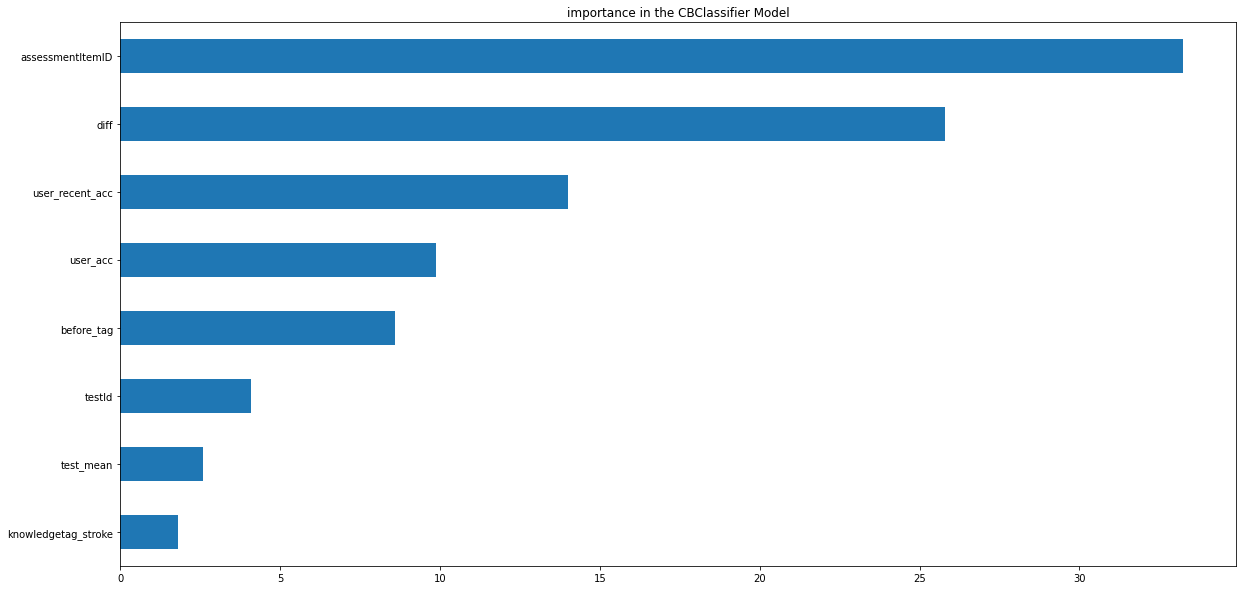

In [613]:
plt.figure(figsize=(20,10))

importances = pd.Series(model_basic.feature_importances_, index = train_pool.get_feature_names())
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("importance in the CBClassifier Model")

plt.show()

In [614]:
print("train ACC :", model_basic.score(train_pool))
print("test ACC :", model_basic.score(test_pool))

pred = model_basic.predict_proba(test_pool)[:,1]
print("test AUC :", roc_auc_score(y_test, pred))

pred1 = model_basic.predict_proba(infer_test_pool)[:,1]
print("test_infer AUC :", roc_auc_score(y_infer_test, pred1))

train ACC : 0.7976171559475099
test ACC : 0.7542561065877128
test AUC : 0.8271916836875763
test_infer AUC : 0.8420647429497254


In [615]:
print("test set 평균, 최대값, 최소값")
print(pred.mean())
print(pred.max())
print(pred.min())

test set 평균, 최대값, 최소값
0.46374160478159704
0.9845519457815392
0.00470912021478538


In [616]:
# inference
infer_cbc = model_basic.predict_proba(infer_pool)[:,1]
infer_cbc[:10]

array([0.74717028, 0.87427543, 0.24533961, 0.84015089, 0.32614214,
       0.80797798, 0.05432905, 0.12613944, 0.20213856, 0.91436873])

In [617]:
print("infer set 평균, 최대값, 최소값")
print(infer_cbc.mean())
print(infer_cbc.max())
print(infer_cbc.min())

infer set 평균, 최대값, 최소값
0.5015185963606372
0.9680479412362808
0.007322660765437063


In [618]:
output = pd.DataFrame({"id":range(744), 'prediction':infer_cbc})
output

,id,prediction
0,0,0.747170
1,1,0.874275
2,2,0.245340
3,3,0.840151
4,4,0.326142
...,...,...
739,739,0.011272
740,740,0.812614
741,741,0.864281
742,742,0.779513


In [619]:
output.to_csv("/opt/ml/input/data/catboost_best_temp10.csv", index=False)
print("output 저장.")

output 저장.


In [620]:
len(output[output.prediction > 0.5])

386

## Ensemble

In [643]:
lgbm_out = pd.read_csv("/opt/ml/input/data/lgbm_best.csv")
# catboost_out = pd.read_csv("/opt/ml/input/data/catboost_best_temp6.csv")
catboost_out = pd.read_csv("/opt/ml/input/data/catboost_best_temp10.csv")
lstmattn_out = pd.read_csv("/opt/ml/input/data/lstm_gcn_tag_ensem.csv")

ensemble_out = (lgbm_out.prediction * 1 + catboost_out.prediction * 3.5 + lstmattn_out.prediction * 1.5) / 6

In [644]:
output = pd.DataFrame({"id":range(744), 'prediction':ensemble_out})
output

,id,prediction
0,0,0.766927
1,1,0.860378
2,2,0.257405
3,3,0.856607
4,4,0.372071
...,...,...
739,739,0.021122
740,740,0.683616
741,741,0.816782
742,742,0.733804


In [645]:
output.to_csv("weighted_sum_26.csv", index=False)
print("output 저장.")

output 저장.


In [646]:
len(output[output.prediction > 0.5])

421

In [625]:
ensemble_out = pd.read_csv("/opt/ml/input/data/output.csv")
len(ensemble_out[ensemble_out.prediction > 0.5])

410